# Data augmentation on Google Flower Photos 
"https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 

In [2]:
tf.__version__

'2.19.0'

In [3]:
# download google flower pictures - this will take some time! 
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
dataset_loc = keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='data/video26', untar=True)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [4]:
# this is the location where the flower pictures are downloaded and stored 
dataset_loc 

'data/video26/datasets/flower_photos'

In [5]:
import pathlib

dataset_loc = pathlib.Path(dataset_loc)
dataset_loc

PosixPath('data/video26/datasets/flower_photos')

In [6]:
len(list(dataset_loc.glob('*/*.jpg')))

3670

In [7]:
roses = list(dataset_loc.glob('roses/*'))
len(roses)

641

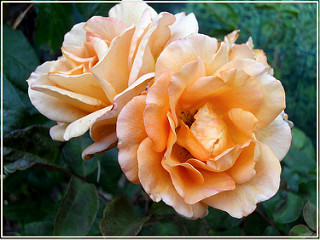

In [8]:
import PIL
PIL.Image.open(roses[2])

In [9]:
tulips = list(dataset_loc.glob('tulips/*'))
len(tulips)

799

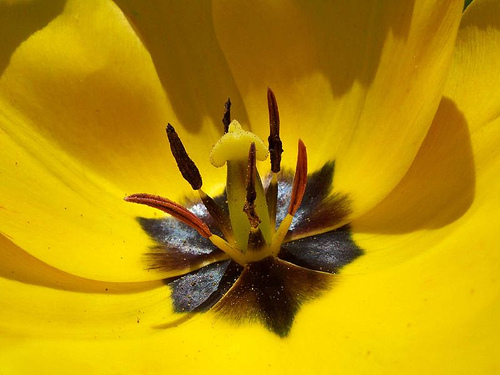

In [10]:
PIL.Image.open(tulips[5])

In [11]:
# list out all the directory names in dataset_loc pathlib 
for dir_name in dataset_loc.iterdir():
    if dir_name.is_dir():
        print(dir_name.name)

roses
sunflowers
daisy
flower_photos
dandelion
tulips


In [12]:
# Create a dictonary of all the flowers and lookup name 
flower_images_dict = {}
for dir_name in dataset_loc.iterdir():
    if dir_name.is_dir():
        flower_images_dict[dir_name.name] = list(dataset_loc.glob(f'{dir_name.name}/*'))

In [13]:
flower_images_dict.keys()

dict_keys(['roses', 'sunflowers', 'daisy', 'flower_photos', 'dandelion', 'tulips'])

In [14]:
# create another dictionary with flower name and labels 
flower_labels_dict = {}
count = 0
for dir_name in dataset_loc.iterdir():
    if dir_name.is_dir():
        flower_labels_dict[dir_name.name] = count
        count+=1

flower_labels_dict

{'roses': 0,
 'sunflowers': 1,
 'daisy': 2,
 'flower_photos': 3,
 'dandelion': 4,
 'tulips': 5}

```
Convert these images to numpy array with pixel density 

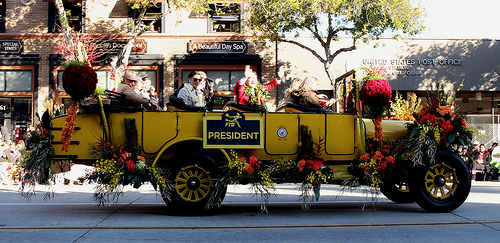

In [15]:
PIL.Image.open(flower_images_dict['roses'][0])

In [16]:
# Now images are in JPG Format. How to convert this image to numpy array? Use CV2 
import cv2 

# testing 
img = cv2.imread(flower_images_dict['roses'][0])
img

array([[[ 14,   3,   0],
        [  1,   0,   2],
        [  0,   0,   6],
        ...,
        [244, 245, 243],
        [244, 245, 243],
        [244, 245, 243]],

       [[  0,   0,   9],
        [  0,   0,   4],
        [  4,   7,   5],
        ...,
        [243, 244, 242],
        [243, 244, 242],
        [243, 244, 242]],

       [[  3,  57, 164],
        [ 30,  63, 132],
        [  0,   0,  19],
        ...,
        [244, 245, 243],
        [244, 245, 243],
        [244, 245, 243]],

       ...,

       [[140, 105,  85],
        [146, 112,  89],
        [147, 113,  90],
        ...,
        [155, 125,  96],
        [152, 122,  93],
        [148, 118,  89]],

       [[148, 114,  91],
        [152, 118,  95],
        [150, 116,  93],
        ...,
        [154, 124,  95],
        [152, 122,  93],
        [150, 120,  93]],

       [[153, 119,  96],
        [154, 120,  97],
        [149, 115,  91],
        ...,
        [151, 122,  95],
        [153, 123,  94],
        [151, 121,  94]]

In [17]:
img.shape

(243, 500, 3)

``` 
Lets see this image 


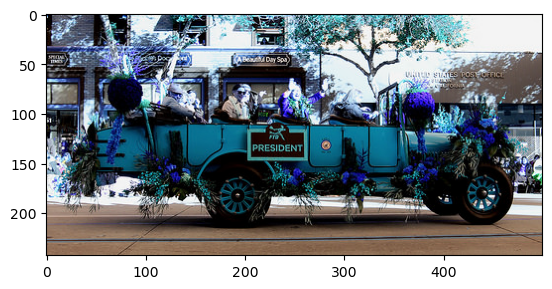

In [18]:
import matplotlib.pyplot as plt 
import matplotlib as mpl 

plt.imshow(img)

```
Every image will be 3D vectors. But the dimensions will not be same. Use cv2.resize as ML models expects all inputs to be in same dimensions

In [19]:
# resize the image to 180x180 
img = cv2.resize(img, (180, 180))

In [20]:
img.shape

(180, 180, 3)

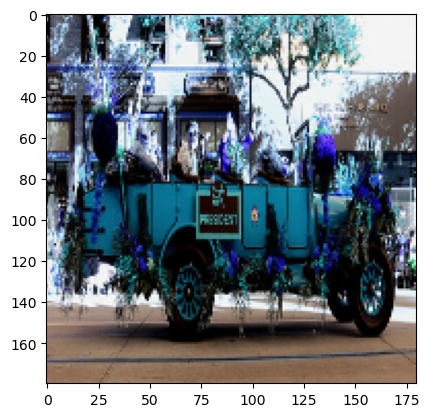

In [21]:
plt.imshow(img)

``` 
We will convert all images to numpy array and resize them 

In [26]:
X, y = [], [] 

# loop over the image dictionary 
for flower_name, image_list in flower_images_dict.items():
    for image in image_list:
        img = cv2.imread(image)
        try:
            resized = cv2.resize(img, (180, 180))
            X.append(resized)
            y.append(flower_labels_dict.get(flower_name))
        except: 
            continue

In [27]:
y[0:6], y[649:655]

([0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1])

In [28]:
# convert the X and y to numpy array 
X = np.array(X)
y = np.array(y)

In [29]:
# perform test train split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2752, 180, 180, 3), (918, 180, 180, 3), (2752,), (918,))

``` 
Perform Data scaling 

In [31]:
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0 

In [32]:
# Now we have scaled input of common dimensions we are ready to train our model 
model_a = keras.models.Sequential() 

# CNN Layers 
model_a.add(keras.layers.Conv2D(16, 3, padding="same", activation="relu"))
model_a.add(keras.layers.MaxPooling2D())
model_a.add(keras.layers.Conv2D(32, 3, padding="same", activation="relu"))
model_a.add(keras.layers.MaxPooling2D())
model_a.add(keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
model_a.add(keras.layers.MaxPooling2D())

# ANN Layer 
model_a.add(keras.layers.Flatten())
model_a.add(keras.layers.Dense(128, activation="relu"))
model_a.add(keras.layers.Dense(5))

# Compile the model 
model_a.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                optimizer=keras.optimizers.Adam(), metrics=["accuracy"])


2025-06-24 13:24:04.198592: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-06-24 13:24:04.198640: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-24 13:24:04.198645: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1750751644.198711   69490 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750751644.198779   69490 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [33]:
model_a.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
# train the model 
model_a.fit(X_train_scaled, y_train, epochs=10)

Epoch 1/10


2025-06-24 13:24:09.577865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2279 - loss: 70.6614
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2193 - loss: 27893.7012
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2164 - loss: 562901.3750
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2401 - loss: 2969492.2500
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2148 - loss: 15955192.0000
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2663 - loss: 33145490.0000
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2098 - loss: 82387784.0000
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2308 - loss: 191559872.0000
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2265 - loss: 305052064.0000
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2220 - loss: 480756992.0000


In [35]:
model_a.evaluate(X_test_scaled, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2013 - loss: 1132848000.0000


[1149617792.0, 0.19063180685043335]

``` 
Model is clearly overfitting

In [36]:
# lets do some predictions 
y_pred = model_a.predict(X_test_scaled)
y_pred[:10]

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([[-8.63980356e+11, -8.69861687e+11, -8.64431899e+11,
        -8.79323251e+11, -8.65052852e+11],
       [-6.64114299e+11, -6.68801171e+11, -6.64268374e+11,
        -6.75851600e+11, -6.65014108e+11],
       [-1.05172559e+12, -1.05901195e+12, -1.05220184e+12,
        -1.07043252e+12, -1.05315952e+12],
       [-6.51985617e+11, -6.56430596e+11, -6.52346982e+11,
        -6.63584571e+11, -6.52739871e+11],
       [-8.72412152e+11, -8.78240203e+11, -8.72950792e+11,
        -8.87947919e+11, -8.73648226e+11],
       [-1.04912834e+12, -1.05614541e+12, -1.04941027e+12,
        -1.06764567e+12, -1.05058016e+12],
       [-7.32809986e+11, -7.38054046e+11, -7.32557738e+11,
        -7.45510732e+11, -7.33544448e+11],
       [-7.11650050e+11, -7.16552012e+11, -7.11919403e+11,
        -7.24262257e+11, -7.12579744e+11],
       [-7.01528146e+11, -7.06410643e+11, -7.01800776e+11,
        -7.13931096e+11, -7.02320214e+11],
       [-5.84697053e+11, -5.88890898e+11, -5.84723464e+11,
        -5.94973753e+11

``` 
Since we didn't provide activation for output layer - it defaulted to linear activation and therefore values are appearning. We can use tensorflow softmax to get the scores 

In [37]:
y_scores = tf.nn.softmax(y_pred)
y_scores[:10]

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

In [38]:
# Now perform argmax to get the index of classification 
y_class = [np.argmax(i) for i in y_scores]
y_class[:5]

[0, 0, 0, 0, 0]

In [39]:
y_test[:5]

array([0, 4, 2, 4, 4])

# Creating augmentation layer

In [40]:
data_agumentation = keras.models.Sequential()
# data_agumentation.add(keras.layers.RandomZoom(0.9))
# data_agumentation.add(keras.layers.RandomContrast(0.9))
data_agumentation.add(keras.layers.RandomRotation(0.2))

```
RandomZoom

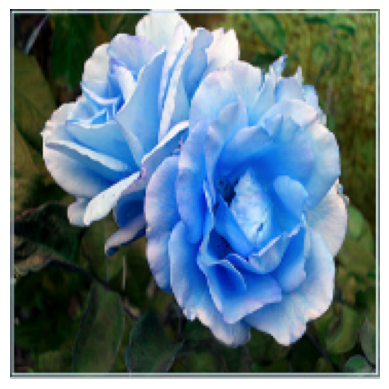

In [41]:
plt.axis("off")
plt.imshow(X[2])

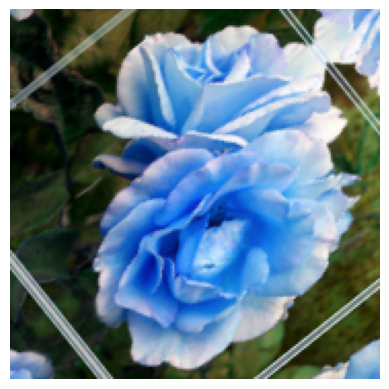

In [42]:
# lets apply  data augmentation for randomzoom=0.9
plt.axis("off")
plt.imshow(data_agumentation(X)[2].numpy().astype("uint8"))

```
Random Constrast

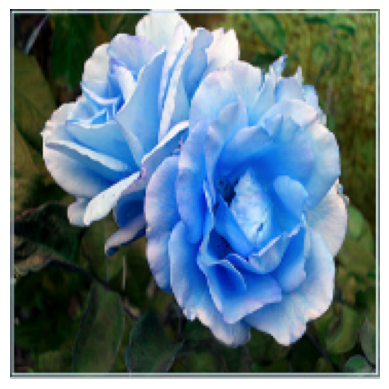

In [43]:
plt.axis("off")
plt.imshow(X[2])

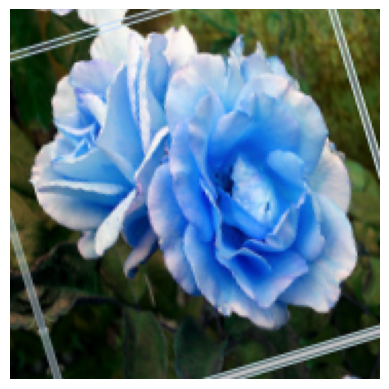

In [44]:
# lets apply  data augmentation for randomzoom=0.9
plt.axis("off")
plt.imshow(data_agumentation(X)[2].numpy().astype("uint8"))

``` 
Random rotation 

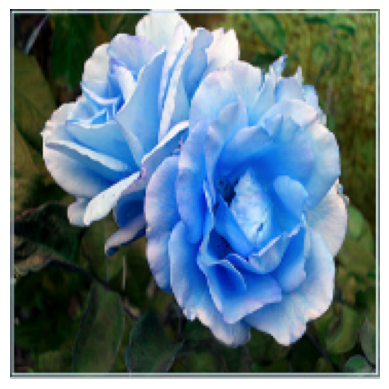

In [45]:
plt.axis("off")
plt.imshow(X[2])

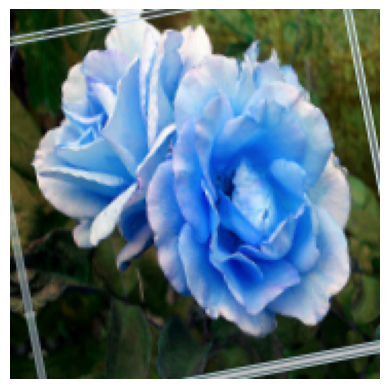

In [46]:
# lets apply  data augmentation for randomzoom=0.9
plt.axis("off")
plt.imshow(data_agumentation(X)[2].numpy().astype("uint8"))

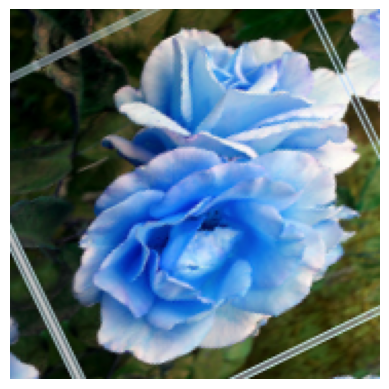

In [47]:
# lets apply  data augmentation for randomratotation again 
plt.axis("off")
plt.imshow(data_agumentation(X)[2].numpy().astype("uint8"))

``` 
Create Data Augmentation Layer

In [48]:
data_augmentation_1 = keras.models.Sequential() 
data_augmentation_1.add(keras.layers.RandomFlip("horizontal", input_shape=(180,180,3)))
data_augmentation_1.add(keras.layers.RandomRotation(0.1))
data_augmentation_1.add(keras.layers.RandomZoom(0.1))

/Users/rohitabhishek/miniconda3/envs/tensor/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


``` 
Build the model 

In [49]:
# Now we have scaled input of common dimensions we are ready to train our model 
model_b = keras.models.Sequential() 

# Data Augmentation Layer 
model_b.add(data_augmentation_1)

# CNN Layers 
model_b.add(keras.layers.Conv2D(16, 3, padding="same", activation="relu"))
model_b.add(keras.layers.MaxPooling2D())
model_b.add(keras.layers.Conv2D(32, 3, padding="same", activation="relu"))
model_b.add(keras.layers.MaxPooling2D())
model_b.add(keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
model_b.add(keras.layers.MaxPooling2D())

# Add a dropout layer
model_b.add(keras.layers.Dropout(0.2))

# ANN Layer 
model_b.add(keras.layers.Flatten())
model_b.add(keras.layers.Dense(128, activation="relu"))
model_b.add(keras.layers.Dense(5))

# Compile the model 
model_b.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                optimizer=keras.optimizers.Adam(), metrics=["accuracy"])


In [50]:
model_b.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# train the model 
model_b.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.2381 - loss: 95.8926
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.2397 - loss: 24127.3184
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.2278 - loss: 522184.8125
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.2319 - loss: 3272539.7500
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.2252 - loss: 15734836.0000
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.2007 - loss: 37083508.0000
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.2075 - loss: 98890544.0000
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.2207 - loss: 127401048.0000
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.2251 - loss: 228577200.0000
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.2152 - loss: 458508448.0000
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.2036 - loss: 745396160

In [52]:
# lets see what is the score on test dataset 
model_b.evaluate(X_test_scaled, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1928 - loss: 35128188928.0000


[34260545536.0, 0.19825707376003265]

``` 
Not very amazing performance but it is not overfitting anymore!